# GANs on MNIST with mlp model
Creating my first GANs using the coursera assignment for MNIST dataset to generate fake handwritten characters with mlp models.

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Generator
The first step is to build the generator component.

Creating a function to make a single layer/block for the generator's neural network. Each block should include a linear transformation to map to another shape, a batch normalization for stabilization, and finally a non-linear activation function (ReLU) so the output can be transformed in complex ways. 

In [3]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_generator_block
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [4]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8,im_dim), 
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

# Noise
To be able to use your generator, we need to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- like a random seed. We generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, noise vector need to be generated at once.

In [5]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_noise
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim , device = device)


# Discriminator
The second component that we need to construct is the discriminator. As with the generator component, we will start by creating a function that builds a neural network block for the discriminator.



In [7]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(0.2)
    )

The discriminator class holds 2 values:


1.   The image dimension
2.   The hidden dimension


The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. We do not need a sigmoid after the output layer since it is included in the loss function.

In [8]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

# Training
Now you can put it all together! First, you will set your parameters:


*   criterion: the loss function
*   n_epochs: the number of times you iterate through the entire dataset when training
*   z_dim: the dimension of the noise vector
*   display_step: how often to display/visualize the images
*   batch_size: the number of images per forward/backward pass
*   lr: the learning rate
*   device: the device type, here using a GPU (which runs CUDA), not CPU


In [12]:
# Set parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = 'cpu'

Now, yoweu can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [13]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (criterion) and you are encouraged to use torch.ones_like and torch.zeros_like instead of torch.ones or torch.zeros. If you use torch.ones or torch.zeros, you'll need to pass device=device to them.

In [14]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    noise_vector = torch.rand(num_images, z_dim, device = device)
    image_gen = gen(noise_vector).detach()
    disc_pred_fake = disc(image_gen)
    disc_loss_fake = criterion(disc_pred_fake,torch.zeros_like(disc_pred_fake,device = device))
    disc_pred_real = disc(real)
    disc_loss_real = criterion(disc_pred_real,torch.ones_like(disc_pred_real,device = device))
    disc_loss = 0.5*(disc_loss_fake + disc_loss_real)

    return disc_loss

In [15]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    noise_vector = torch.rand(num_images, z_dim, device = device)
    gen_image = gen(noise_vector)
    disc_pred = disc(gen_image)
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred,device = device))

    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3877330635786054, discriminator loss: 0.4120909913182257


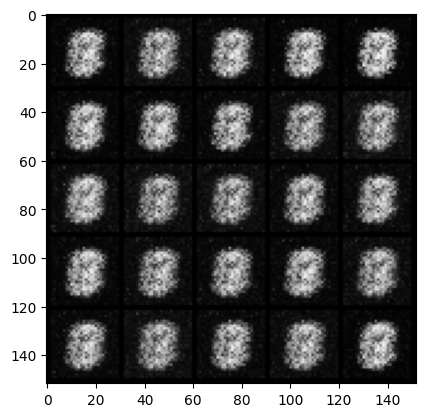

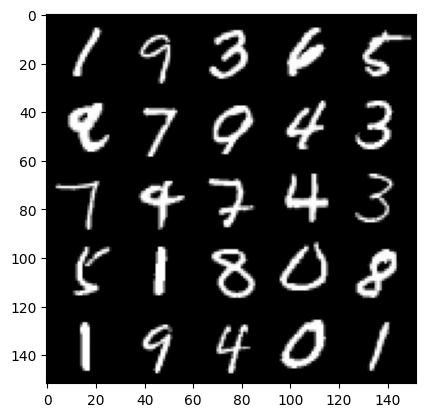

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.7200763225555418, discriminator loss: 0.2854185568690296


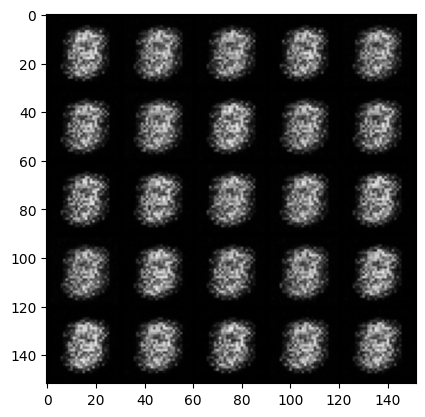

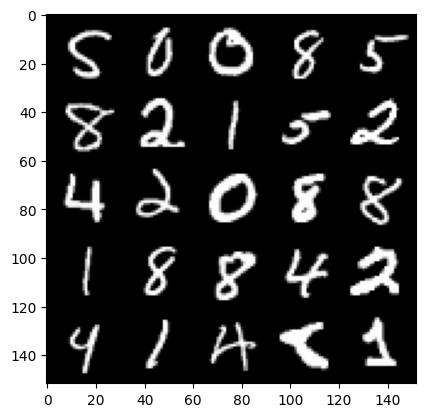

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.0348143723011014, discriminator loss: 0.1611352959275245


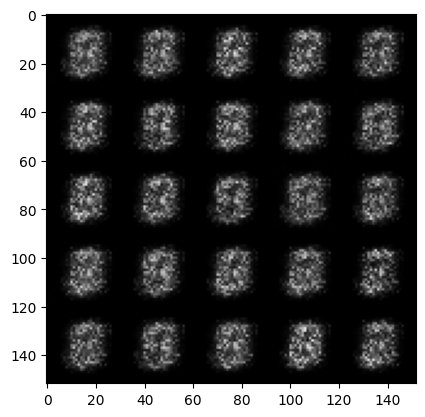

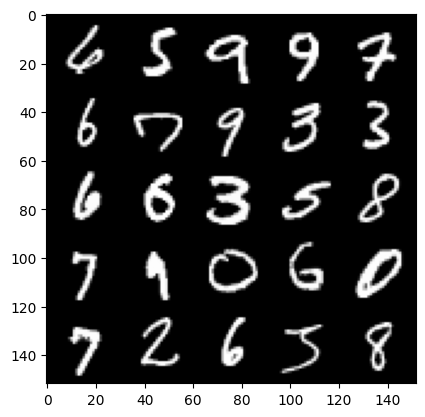

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.7715533776283288, discriminator loss: 0.2005133908092977


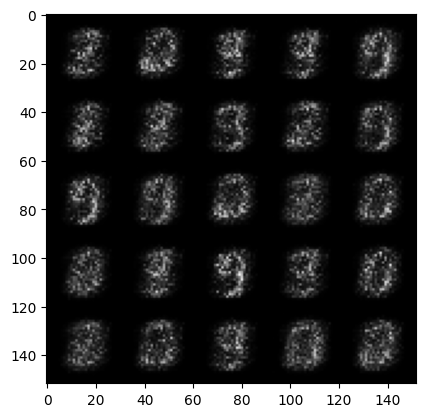

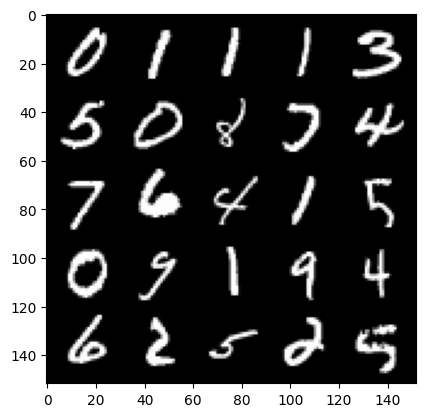

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7272989296913148, discriminator loss: 0.2001061810553074


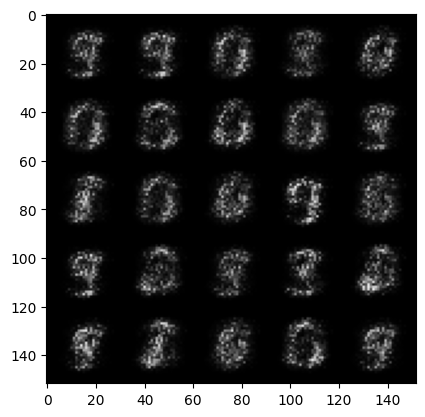

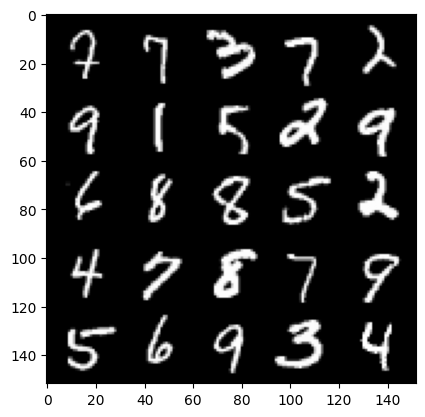

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.0171057748794543, discriminator loss: 0.16144521604478376


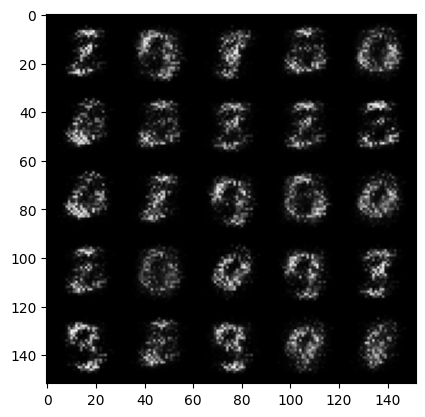

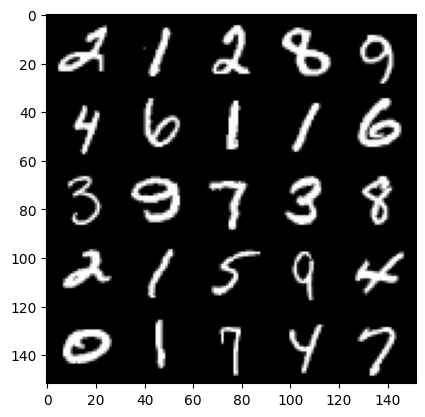

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.376302160263064, discriminator loss: 0.13136479569971563


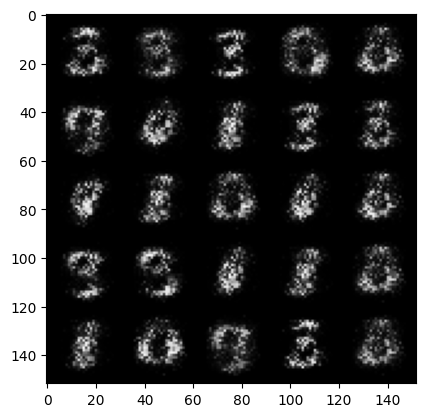

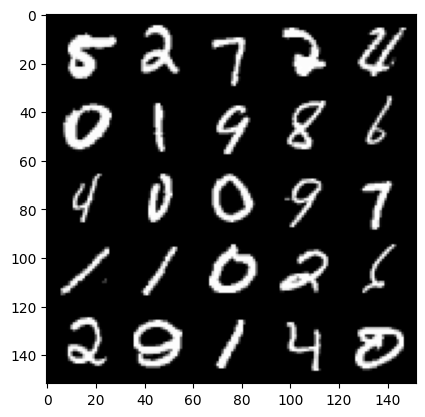

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.8861420140266403, discriminator loss: 0.09951063217222672


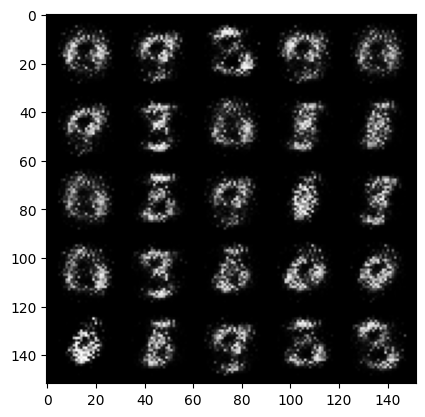

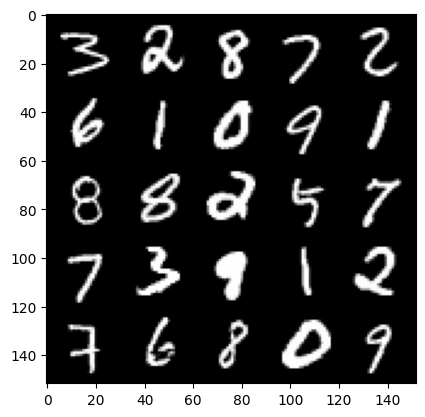

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.3692848157882684, discriminator loss: 0.0771584513261915


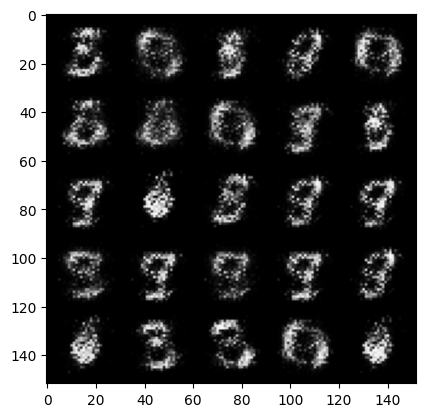

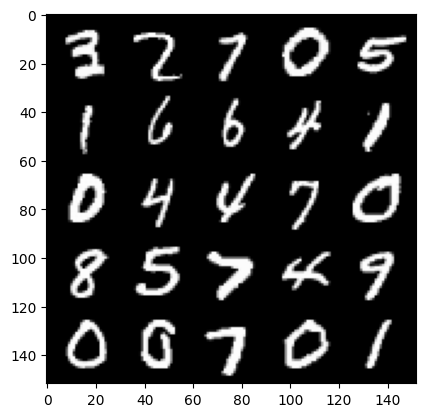

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.4650961346626246, discriminator loss: 0.08250557094067341


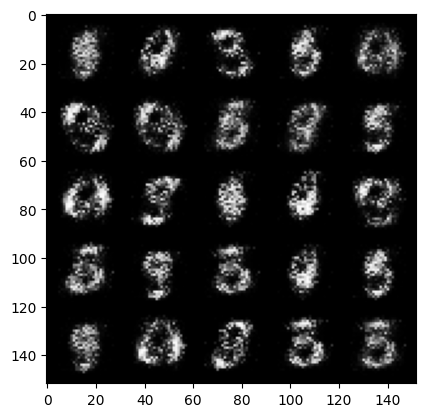

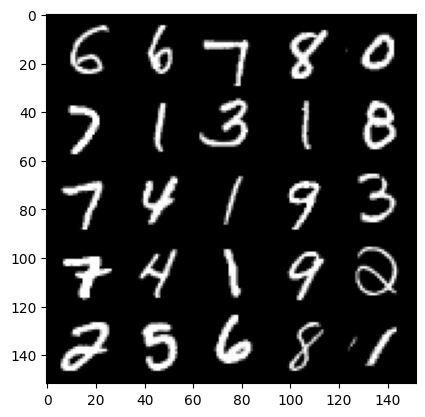

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.80551769208908, discriminator loss: 0.06683187798410656


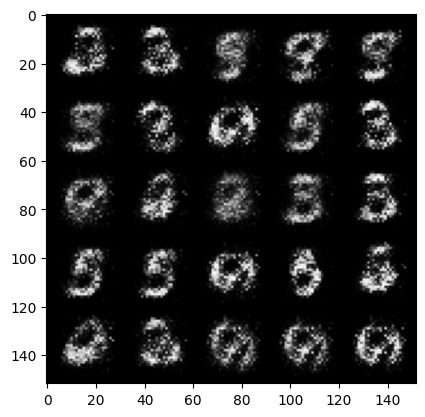

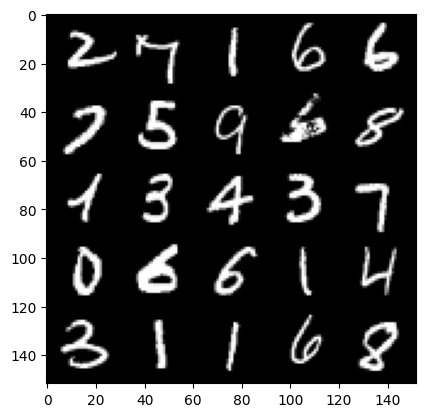

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.93179028749466, discriminator loss: 0.05930808129161597


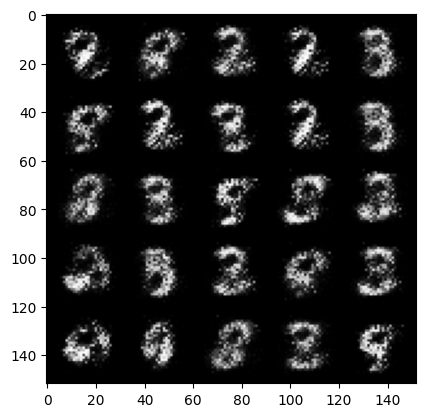

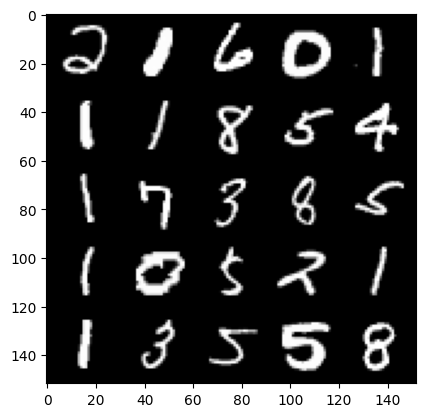

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 4.04271231746673, discriminator loss: 0.051480042021721566


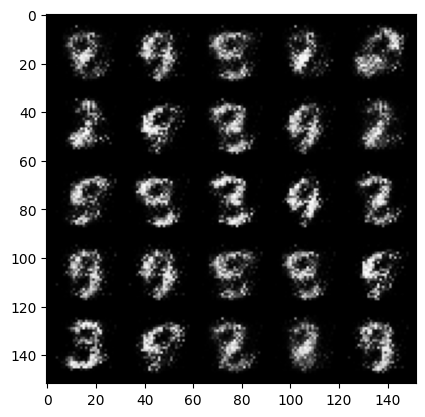

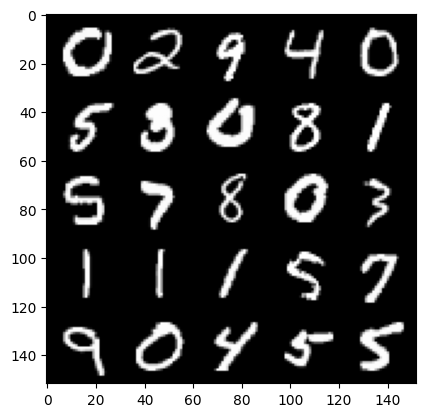

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 4.220922218322754, discriminator loss: 0.05449933900311585


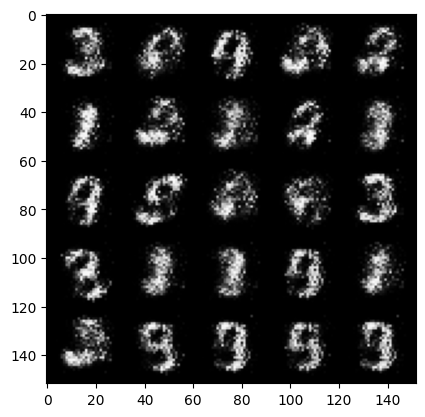

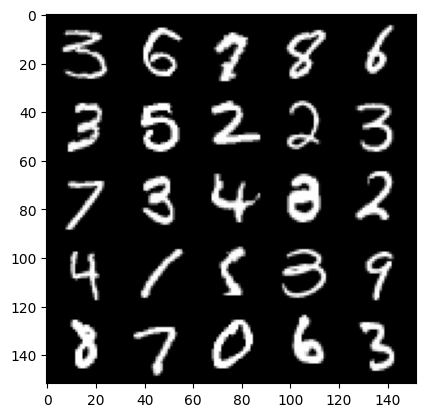

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.343497002601625, discriminator loss: 0.053612926688045265


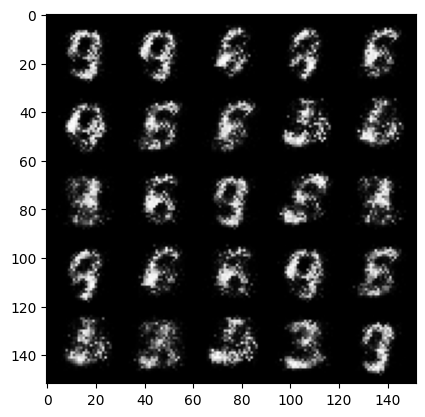

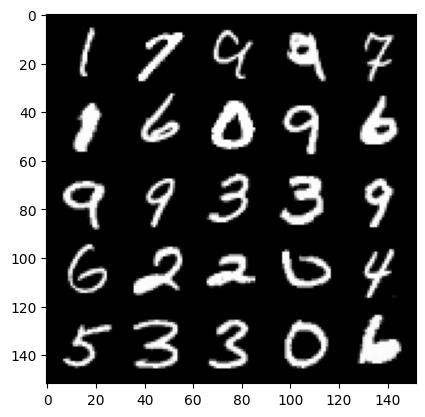

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 4.285681343078612, discriminator loss: 0.05638501123338938


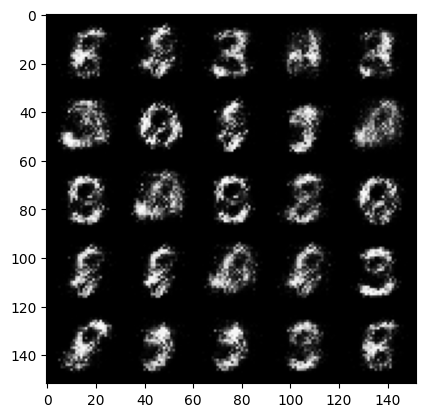

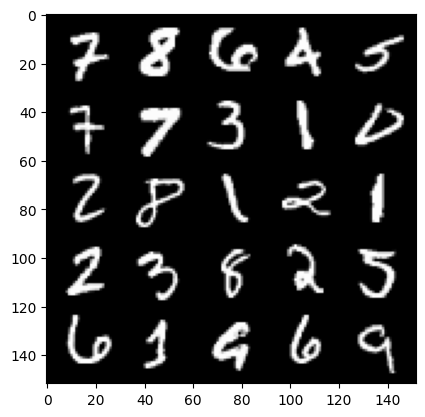

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 4.206884172439569, discriminator loss: 0.060597653217613685


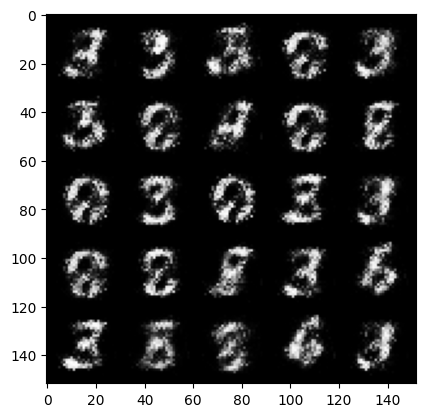

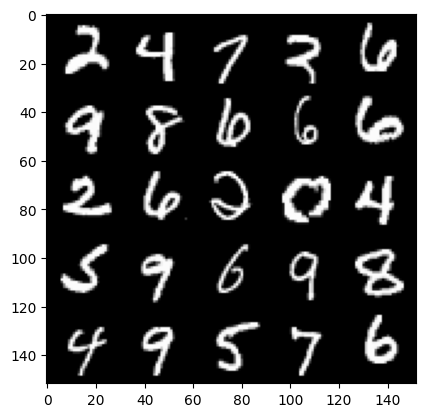

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 4.1518000826835655, discriminator loss: 0.0561685698851943


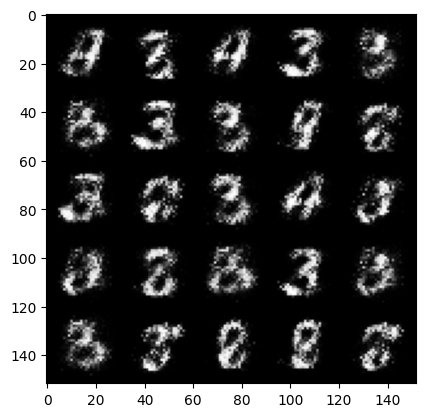

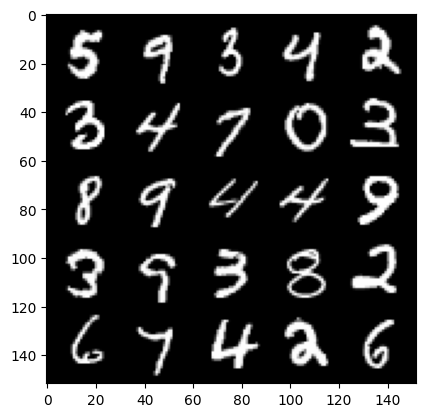

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 4.471973439216611, discriminator loss: 0.046220097631216046


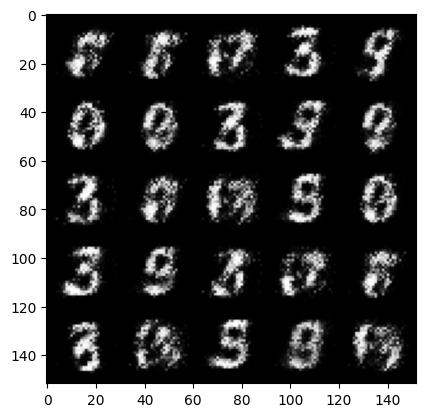

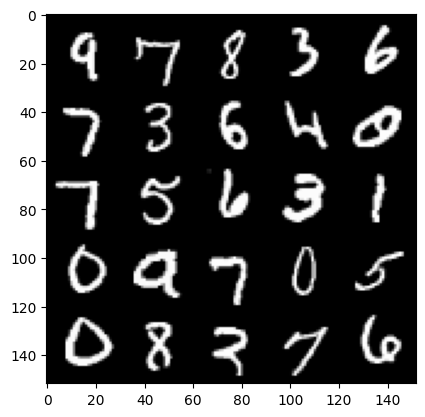

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.516517617225649, discriminator loss: 0.053916790802031704


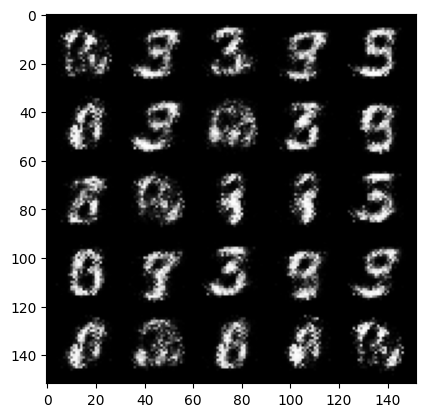

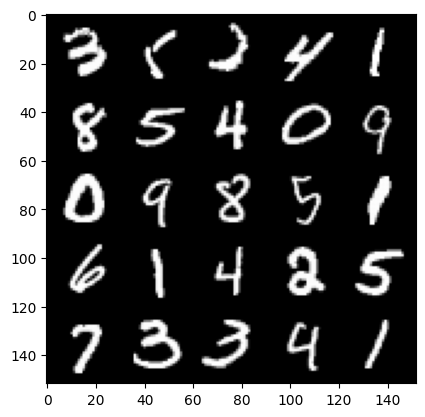

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 4.433404380321499, discriminator loss: 0.05222575473412872


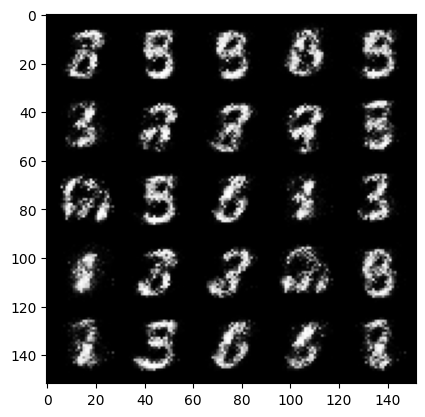

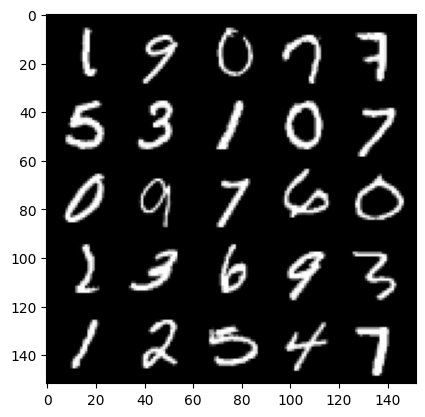

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 4.258334673404693, discriminator loss: 0.05682291065901515


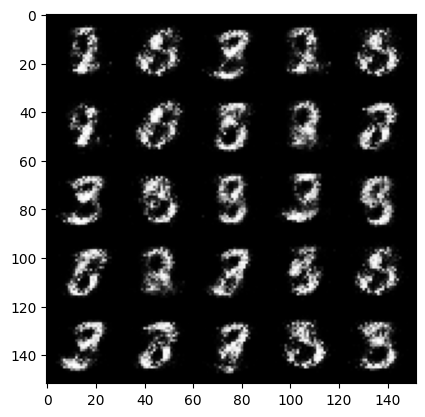

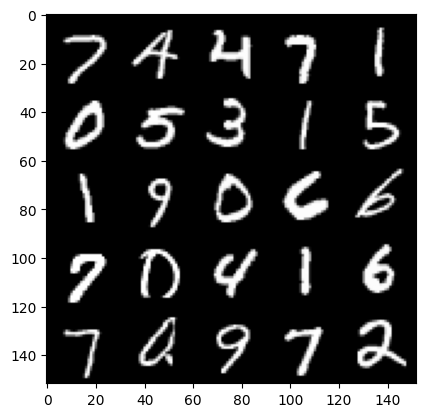

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 4.237482202529907, discriminator loss: 0.05634722319245341


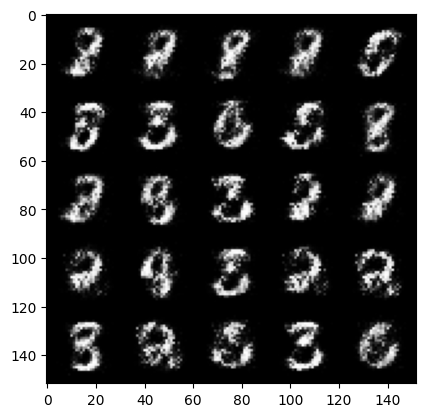

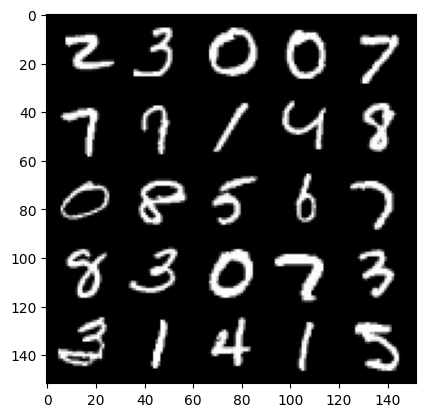

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 4.201870004653929, discriminator loss: 0.06387258560210467


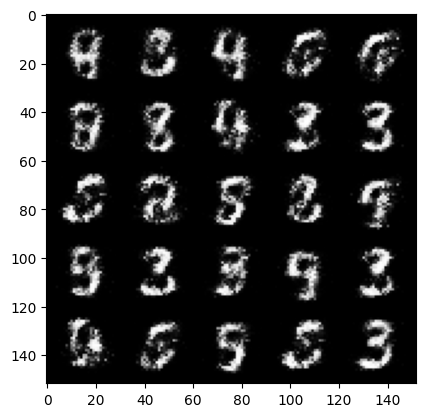

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 4.1710828247070335, discriminator loss: 0.06262657355144617


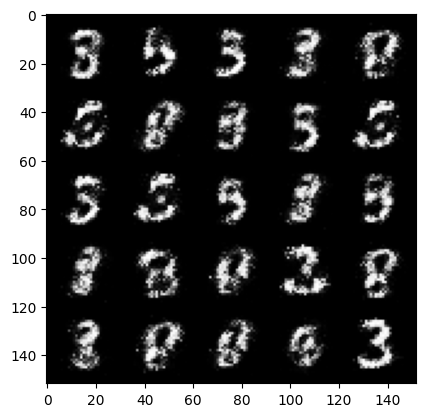

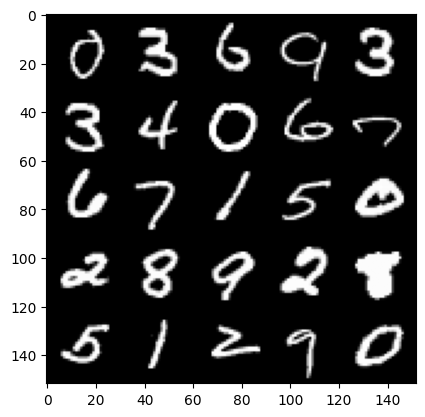

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 4.072192043304444, discriminator loss: 0.0790675311759114


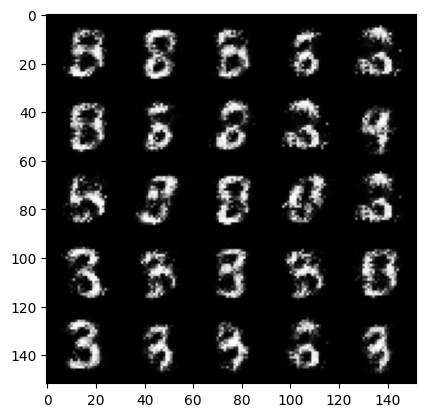

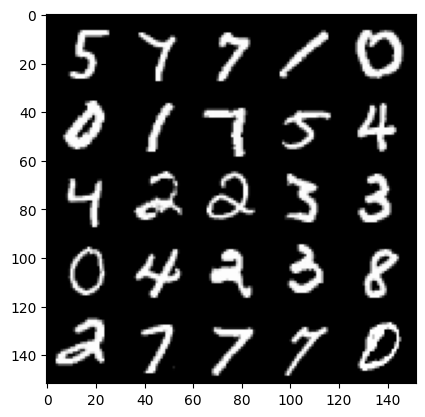

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 4.071784000396726, discriminator loss: 0.0780251248702407


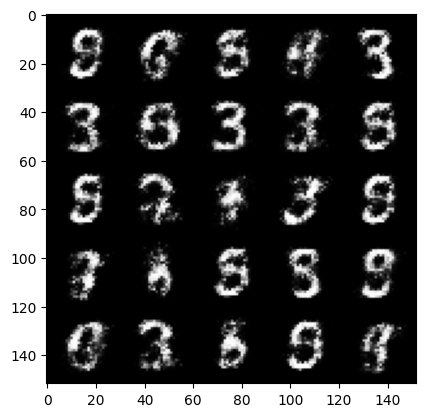

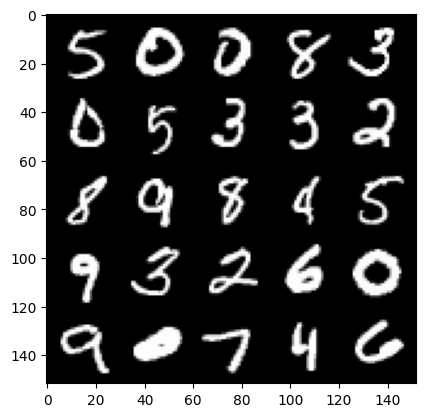

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 4.094097665786743, discriminator loss: 0.07457889422401778


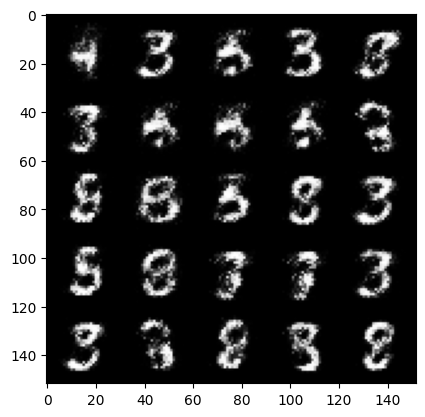

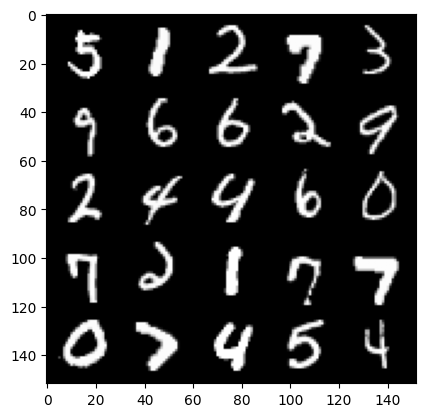

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 4.071466282367704, discriminator loss: 0.08193820878863332


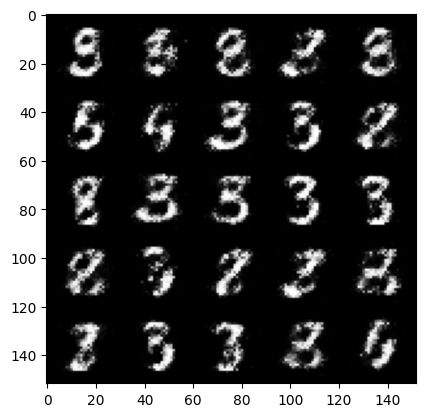

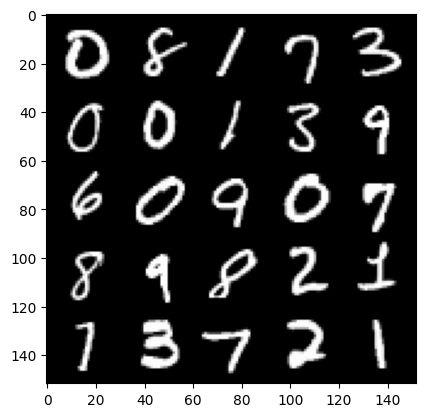

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 4.23172415018082, discriminator loss: 0.07823091916739941


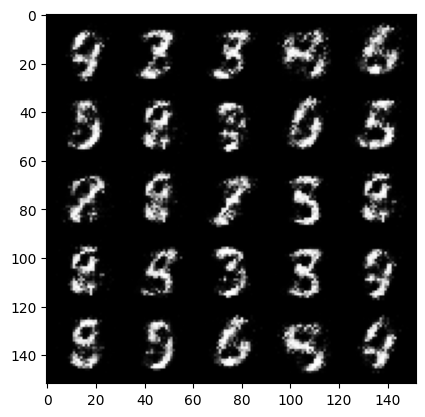

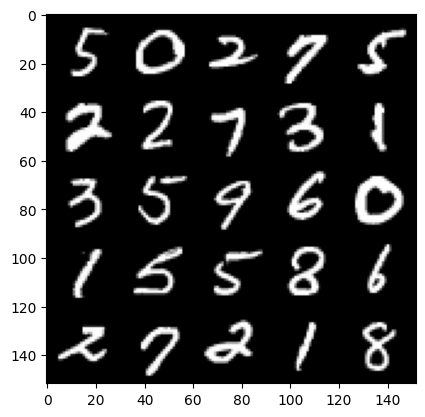

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 4.213702188491823, discriminator loss: 0.08504616827517743


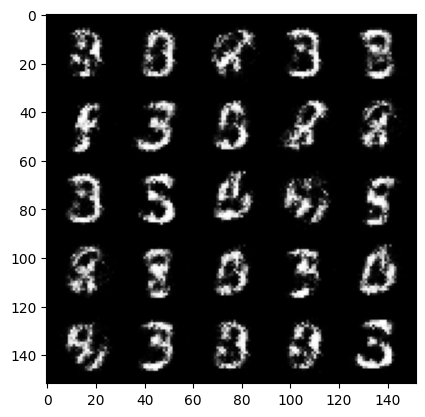

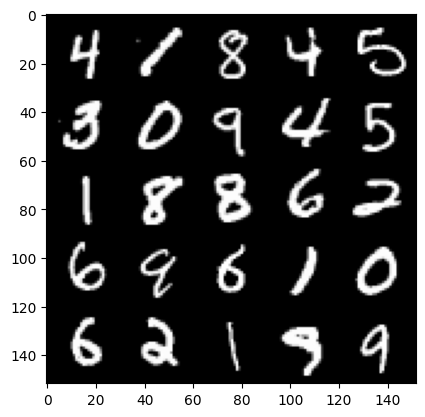

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 4.0684392118454, discriminator loss: 0.10086573822051285


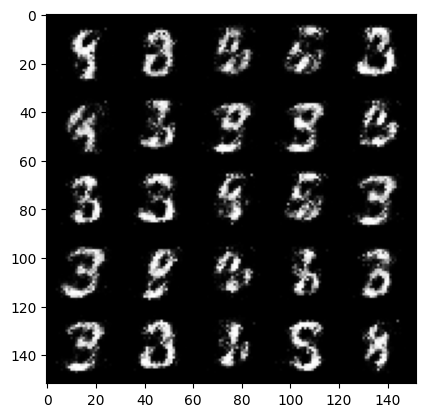

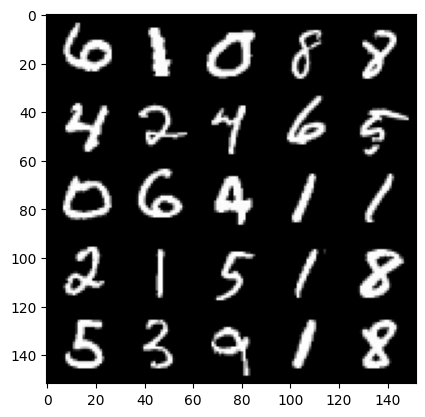

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 4.255498160362244, discriminator loss: 0.09174347598850734


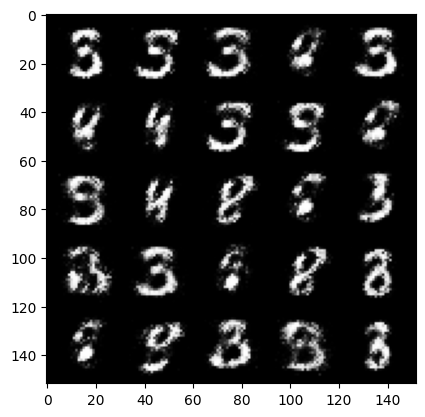

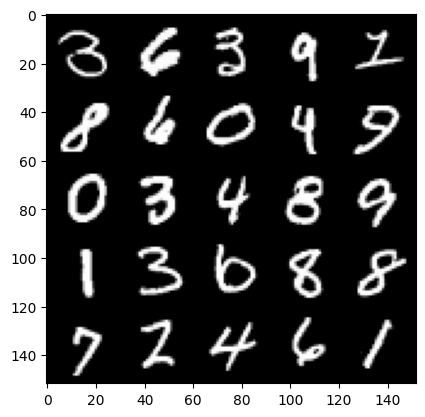

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 4.170284207344053, discriminator loss: 0.10637420507520452


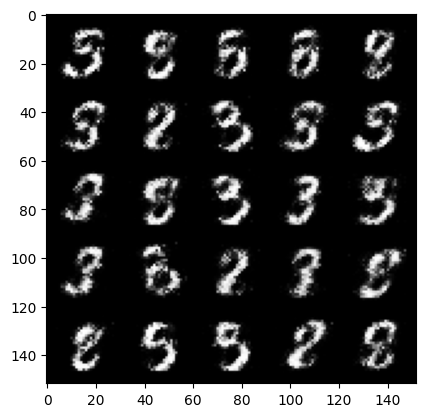

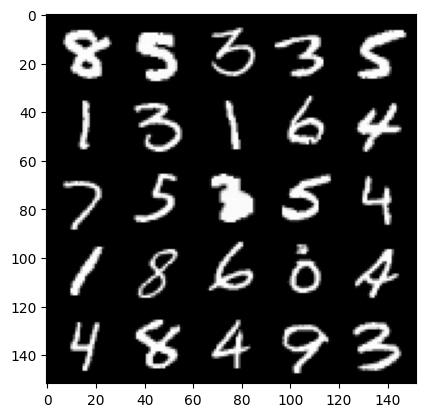

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 3.908491464614864, discriminator loss: 0.11583612201362858


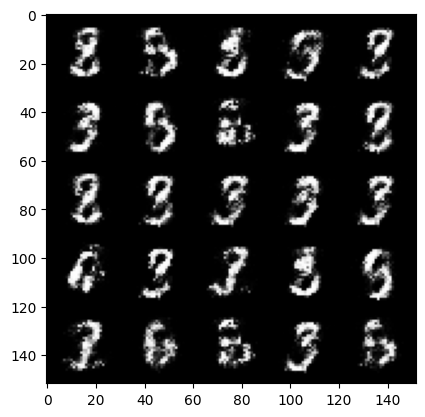

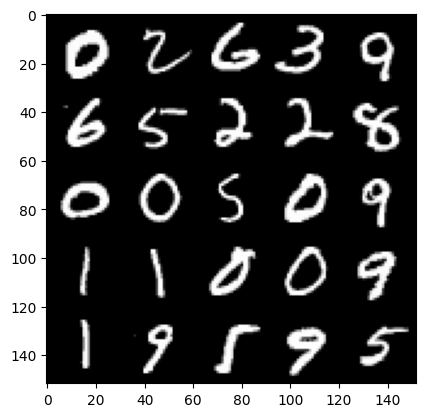

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 3.9502190537452706, discriminator loss: 0.10284038949757818


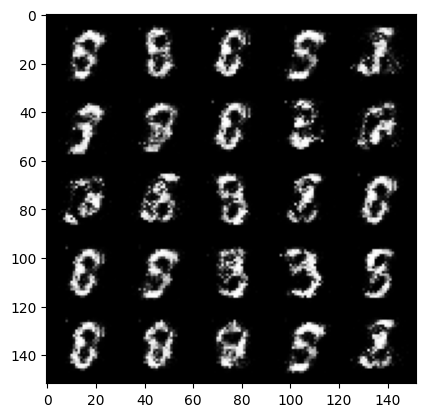

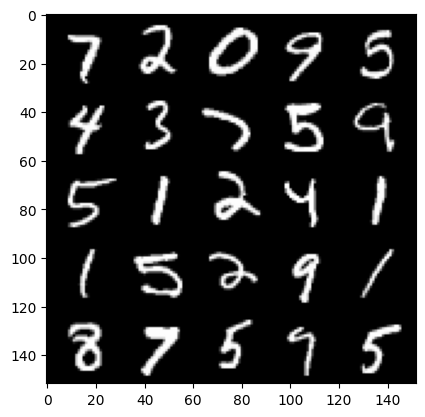

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 4.1249886574745185, discriminator loss: 0.10356757693737743


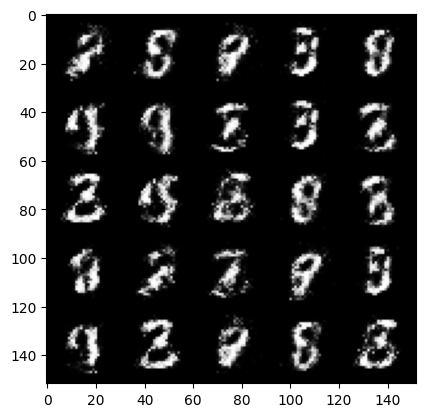

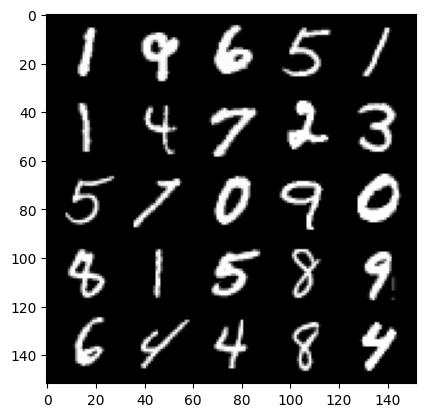

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 3.934884768486022, discriminator loss: 0.10116817291826014


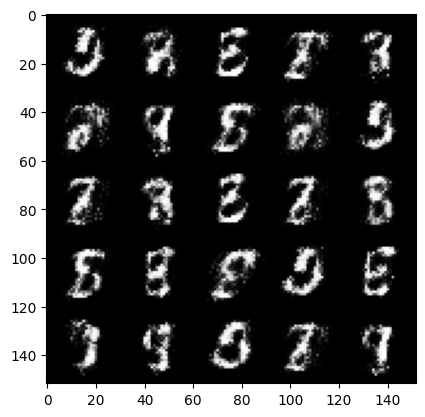

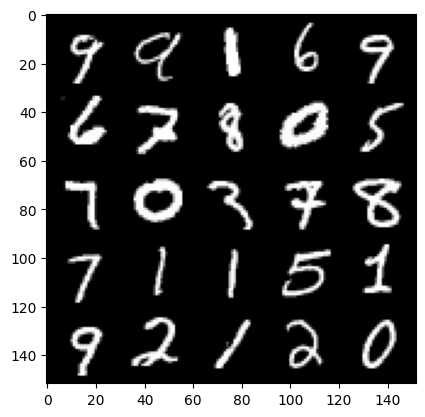

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 3.7864679026603643, discriminator loss: 0.10840079278498882


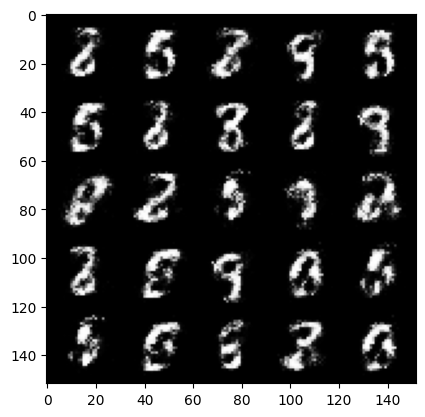

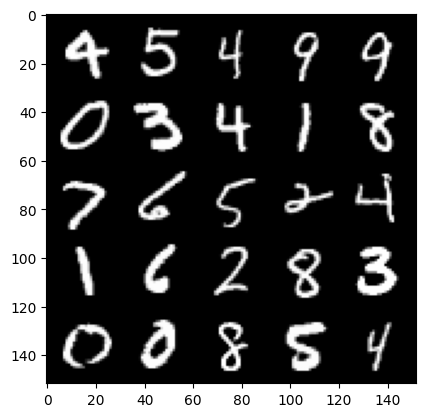

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.748435060024262, discriminator loss: 0.1126086549460888


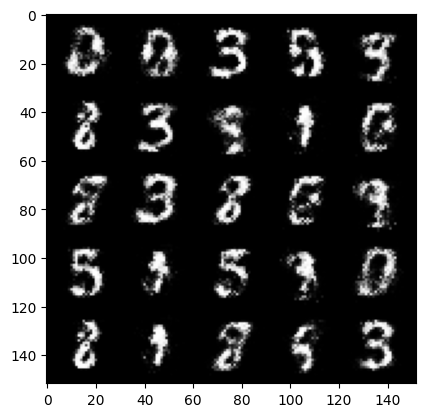

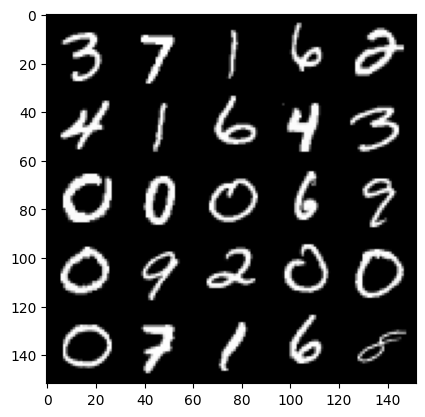

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 3.659944852828982, discriminator loss: 0.1278768848106265


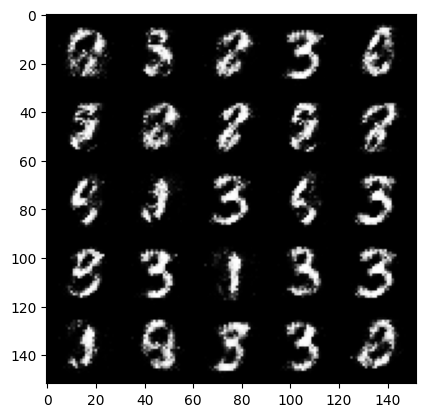

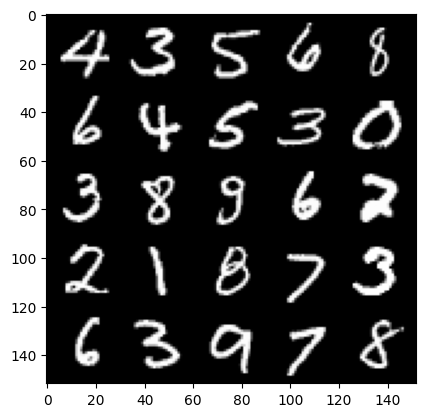

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# OPTIONAL PART

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
            gen_loss.backward()
            gen_opt.step()


        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
